# **Kilonova Spectroscopic Identification Using Deep Learning**

**Notebook Imports**

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import sys

from tensorflow import keras
import tensorflow as tf
from scipy import interpolate
import tensorflow.keras.layers as tfkl
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage

**Loading the data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/IC_2022/new_snI_data.pkl', 'rb') as f:
  snI_data = pickle.load(f)

with open('/content/drive/MyDrive/IC_2022/new_snII_data.pkl', 'rb') as f:
  snII_data = pickle.load(f)

In [4]:
kn_seds = np.load('/content/drive/MyDrive/IC_2022/kn_seds_VAE_cut_interp_test.npy')

In [5]:
with open('/content/drive/MyDrive/IC_2022/GW170817.json', 'r') as f:
  kn_real = json.load(f)

# **Cleansing and Pre-processing of the data**.

The first step of the program is the pre-processing of the data. 

The Supernovas' data are real therefore we will have to pay a little more attention to them. They were disposed in the form of a dictionary, so first we created three NumPy arrays: one for the SEDs data that will be used as network input, the other for its names, so we have a catalog of all the Supernovas analyzed and the third to save the luminosity distance of the SEDs.

For that, we selected only the data with flux measured in $~erg~s^{-1}cm^{-2}Å^{-1}$ and that has a defined luminosity distance.

In [6]:
seds_snI = []
namesI = []
lumdistI = []
for i, sn in snI_data.items():
  if 'Uncalibrated' not in sn['u_flux'] and sn['lumdist'] != 0:
    for sed in sn['spectra']:
      seds_snI.append(sed)
      namesI.append(i)
      lumdistI.append(sn['lumdist'])
seds_snI = np.array(seds_snI, dtype='object')
nameI = np.array(namesI)

# We do the same for both Supernova types

seds_snII = []
namesII = []
lumdistII = []
for i, sn in snII_data.items():
  if 'Uncalibrated' not in sn['u_flux'] and sn['lumdist'] != 0:
    for sed in sn['spectra']:
      seds_snII.append(sed)
      namesII.append(i)
      lumdistII.append(sn['lumdist'])
sedsII = np.array(seds_snII, dtype='object')
nameII = np.array(namesII)

We will use the luminosity distance to standardize the fluxes of the SEDs at a redshift 0, so they are likewise the Kilonovae's simulated data that are all standardized at 10pc. To accomplish that, we use:

$F_{10pc} = F_{Observed} * \left(\frac{lumdist}{10pc}\right)^2$

In [7]:
def standardize_flux(data, lumdist):
  standardized_data = []
  for i, sed in enumerate(data):
    sed_10pc = np.zeros_like(sed)
    for j, dp in enumerate(sed):
      sed_10pc[j][0] = dp[0]
      sed_10pc[j][1] = (dp[1] * (lumdist[i]*10**6 / 10)**2)
    standardized_data.append(sed_10pc)
  standardized_data = np.array(standardized_data, dtype='object')
  return standardized_data

In [8]:
sedsI = standardize_flux(seds_snI, lumdistI)
sedsII = standardize_flux(seds_snII, lumdistII)

Then we can begin to make the necessary cuts in the data.

We selected only the SEDs that are within the range of wavelengths that we chose to use, that is 4000-8500 angstroms. We also did a cut on the SEDs so that we only have the datapoints within the chosen range.

In [9]:
def cut(data, data_name, initial_wl, final_wl):
  data_cut = []
  name_cut = []
  for i, sed in enumerate(data):
    if min(sed[:,0]) <= initial_wl and max(sed[:,0]) >= final_wl:
      x = np.where(sed[:,0] <= initial_wl)[0][-1]
      y = np.where(sed[:,0] >= final_wl)[0][0]
      if x < y:
        data_cut.append(sed[x:y+1])
        name_cut.append(data_name[i])
  data_cut = np.array(data_cut, dtype='object')
  name_cut = np.array(name_cut)
  return data_cut, name_cut

In [10]:
sedsI_cut, namesI_cut = cut(sedsI, namesI, 4000.0, 8500.0)
sedsII_cut, namesII_cut = cut(sedsII, namesII, 4000.0, 8500.0)

Last we make a selection, maintaining only the Supernovas' SEDs without the baseline and then remove all the SEDs that contain negative fluxes

In [11]:
def no_baseline_cut(data, data_name, x_times):
  index = []
  for i, sed in enumerate(data):
    flux = [dp[1] for dp in sed]
    flux = np.array(flux)
    std = np.std(flux)
    m = np.mean(flux)
    comparison = flux[flux > m+std*x_times]    # append every flux bigger than the mean flux plus 8 times its standard deviation
    comparison = np.array(comparison)
    if comparison.shape[0] >= 1 or any(z < 0 for z in sed[:,1]):
      index.append(i)                    # append to the index list the number of the SED that contain fluxes bigger than the comparison made or that contain any negative flux
  data_cut = np.delete(data, index)      # delete the SEDs by its index numbers
  data_name_cut = np.delete(data_name, index)
  return data_cut, data_name_cut

In [12]:
sedsI_bl, namesI_bl = no_baseline_cut(sedsI_cut, namesI_cut, 8)
sedsII_bl, namesII_bl = no_baseline_cut(sedsII_cut, namesII_cut, 8)

Here we chose to concatenate the SEDs from both Supernovas' type, so that we have a bigger set of data to input on the network later.

In [13]:
sn_seds = np.concatenate((sedsI_bl, sedsII_bl), dtype='object')
sn_names = np.concatenate((namesI_bl, namesII_bl))

In [14]:
len(sn_seds)

2226

And then we interpolate the data between the data range selected, so that we have the same number of points in all the SEDs.

In [15]:
def interpol(sed, initial_wl, final_wl, n_points):
  wl_range = np.linspace(initial_wl, final_wl, n_points)
  flux_interp = np.interp(wl_range, sed[:,0], sed[:,1])
  sed_interpol = np.vstack([wl_range, flux_interp]).T
  return sed_interpol

In [16]:
sn_seds_interpol = [interpol(sed, 4000, 8500, 200) for sed in sn_seds]
sn_seds_interpol = np.array(sn_seds_interpol)

Finally, we can move with the treatment of the Kilonovae's data.
They are simulated data, i.e. they need a different type of treatment, one that make them more relatable to what we have in real data.

First, we will make a cut so that we obtain the same amount of Kilonovae's SEDs that we have of Supernovae's, and interpolate the data.

In [17]:
id_kn_seds_cut = np.random.choice(range(kn_seds.shape[0]), sn_seds.shape[0], replace=False)
kn_seds_cut = kn_seds[id_kn_seds_cut]

In [18]:
kn_seds_interpol = np.zeros((kn_seds_cut.shape[0], 200, 2))
for i, sed in enumerate(kn_seds_cut):
  kn_interp_sed = interpol(sed, 4000, 8500, 200)
  kn_seds_interpol[i] = kn_interp_sed

Lastly, we add noise to the flux of the Kilonovae's SEDs. It will make the simulated data more similar to the real data, and assure that the model don't use that difference to recognize between Supernovae's and Kilonovae's SEDs.

In [19]:
kn_seds_n = kn_seds_interpol.copy()
for sed in kn_seds_n:
  flux = sed[:,1]
  random_sigma = np.random.uniform(0.01*flux,0.1*flux)
  error = np.random.normal(loc=0.0, scale=abs(random_sigma))
  new_flux = flux + error
  for i, dp in enumerate(sed):
    sed[i, 1] = new_flux[i]

The last set of data we have are the real SEDs of the Kilonova GW170817, that will be used to test the effectiveness of the neural network.

This set will go through the same preprocessing as the Supernovae's data.

In [20]:
kn_real_sed = []          # creates an array with the data of the real KN
kn_time = []                 # and an array for the detection time in MJD
for i in range(len(kn_real['GW170817']['spectra'])):
  sed = []
  for j in range(len(kn_real['GW170817']['spectra'][i]['data'])):
    x = np.array(kn_real['GW170817']['spectra'][i]['data'][j])
    sed.append(x.astype('float'))
  kn_real_sed.append(np.array(sed))
  y = np.array(kn_real['GW170817']['spectra'][i]['time'])
  kn_time.append(y.astype('float'))
kn_real_sed = np.array(kn_real_sed, dtype='object')
kn_time = np.array(kn_time)
lumdist_KN = [float(kn_real['GW170817']['lumdist'][0]['value'])]*len(kn_real_sed)

In [21]:
kn_10pc = standardize_flux(kn_real_sed, lumdist_KN)

In [22]:
seds_real_kn_cut, kn_time_cut = cut(kn_10pc, kn_time, 4000.0, 8500.0)

In [23]:
kn_real_interpol = np.zeros((seds_real_kn_cut.shape[0], 200, 2))
for i, sed in enumerate(seds_real_kn_cut):
  kn_interp_sed = interpol(sed, 4000, 8500, 200)
  kn_real_interpol[i] = kn_interp_sed

**Taking a look on the data**

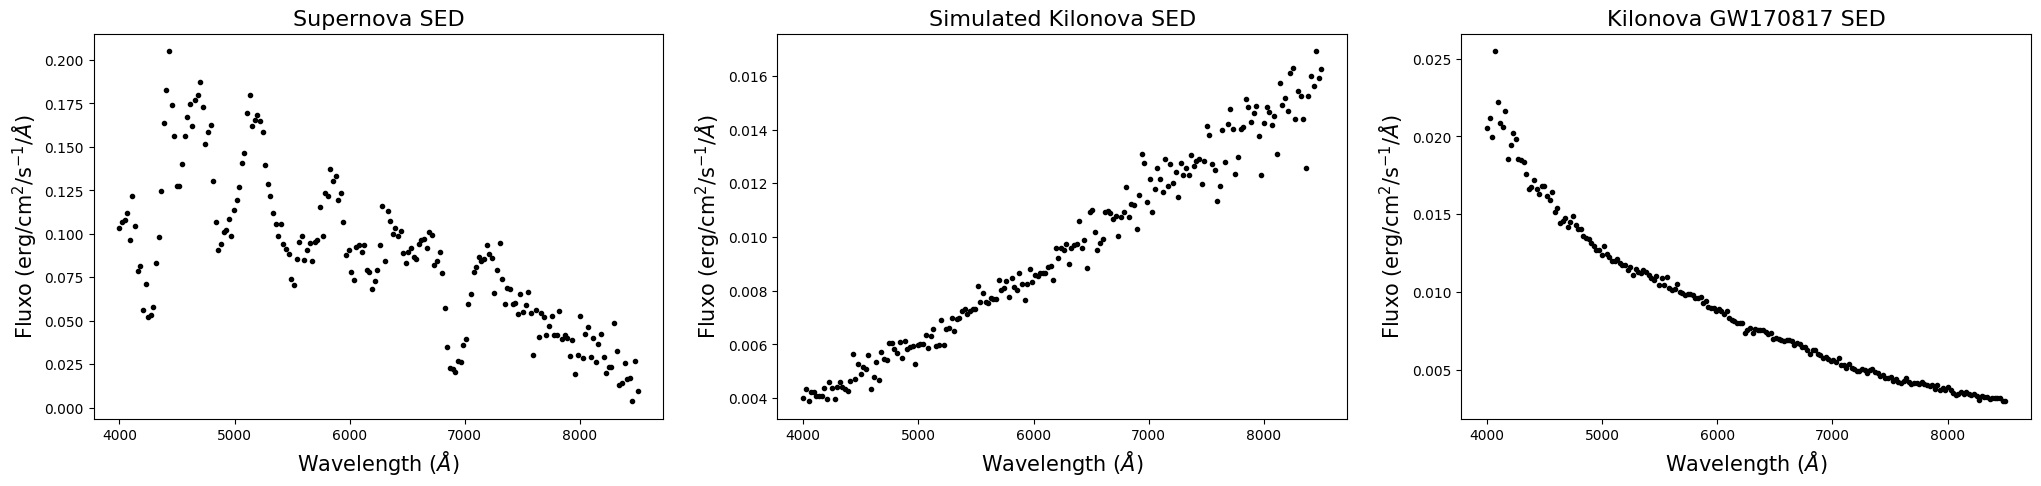

In [24]:
plt.figure(figsize=(25, 5)) 

plt.subplot(1, 3, 1)
plt.plot(sn_seds_interpol[1,:,0], sn_seds_interpol[1,:,1], 'k.')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Fluxo (erg/cm$^2$/s$^{-1}/\AA$)', fontsize=15)
plt.title('Supernova SED', fontsize=16)

plt.subplot(1, 3, 2) 
plt.plot(kn_seds_n[1,:,0], kn_seds_n[1,:,1], 'k.')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Fluxo (erg/cm$^2$/s$^{-1}/\AA$)', fontsize=15)
plt.title('Simulated Kilonova SED', fontsize=16)

plt.subplot(1, 3, 3) 
plt.plot(kn_real_interpol[1,:,0], kn_real_interpol[1,:,1], 'k.')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Fluxo (erg/cm$^2$/s$^{-1}/\AA$)', fontsize=15)
plt.title('Kilonova GW170817 SED', fontsize=16)

plt.show()

By taking a look at the data, we also noticed that the Supernovas' SEDs were still easy to find, mostly because of the difference between simulated and real data. For that reason, we implemented a SciPy function to apply a uniform filter on the Supernovas' SEDs, so that the curves observed in the graphic become less accentuated.

In [25]:
sn_uniform = sn_seds_interpol.copy()
for i in range(len(sn_seds_interpol)):
  sn_uniform[i][:,1] = ndimage.uniform_filter1d(sn_seds_interpol[i][:,1], 50)

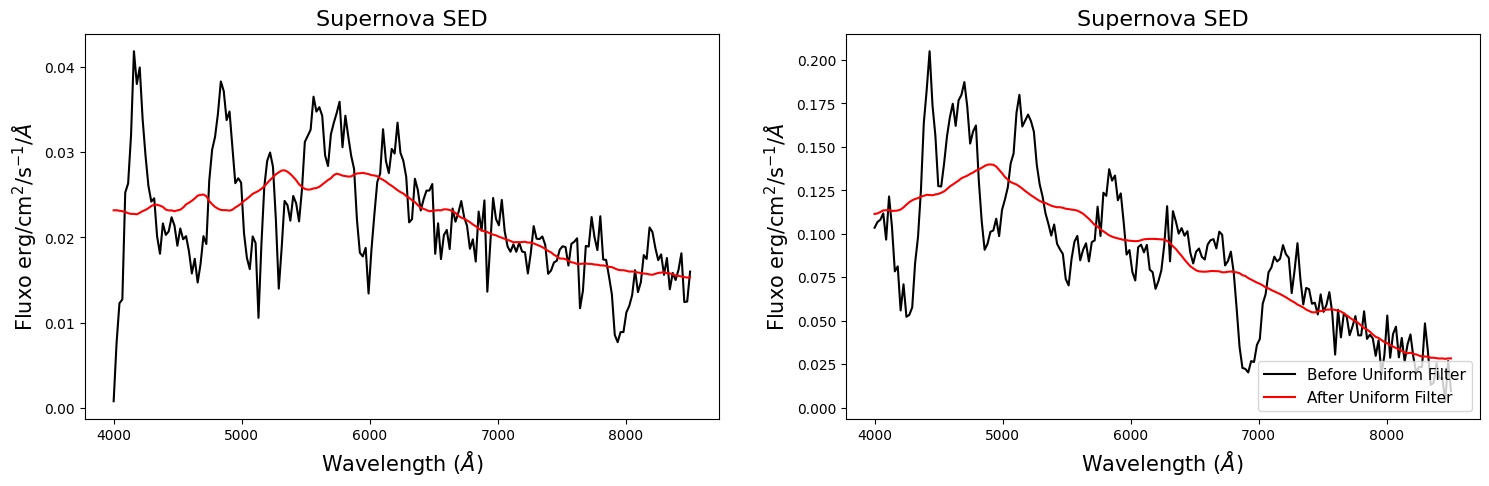

In [26]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(sn_seds_interpol[0,:,0], sn_seds_interpol[0,:,1], 'k-')
plt.plot(sn_uniform[0,:,0], sn_uniform[0,:,1], 'r-')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Fluxo erg/cm$^2$/s$^{-1}$/$\AA$', fontsize=15)
plt.title('Supernova SED', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(sn_seds_interpol[1,:,0], sn_seds_interpol[1,:,1], 'k-', label='Before Uniform Filter')
plt.plot(sn_uniform[1,:,0], sn_uniform[1,:,1], 'r-', label='After Uniform Filter')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel(r'Fluxo erg/cm$^2$/s$^{-1}$/$\AA$', fontsize=15)
plt.title('Supernova SED', fontsize=16)

plt.legend(loc='lower right', fontsize=11)
plt.show()

##**Neural Network**

Now we can begin to work on the neural network.

First, we will define the input and final test arrays and it's labels, as well as normalize the SEDs between [0,1].

In [27]:
input_nn = np.concatenate((sn_seds_interpol, kn_seds_n))            # Creates an array with both the kilonova and supernova data for the input of the network
input = [MinMaxScaler().fit_transform(sed) for sed in input_nn]      # Normalize the fluxes into the range of [0, 1]
input = np.array(input)
labels = [0]*(len(sn_seds_interpol)) + [1]*(len(kn_seds_n))
labels = tf.keras.utils.to_categorical(labels, num_classes=2)

In [28]:
test_kn = [MinMaxScaler().fit_transform(sed) for sed in kn_real_interpol]       # Creates an array with the SEDs of GW170817 that will be used to test the network
test_kn = np.array(test_kn)
labels_kn = [1]*(len(kn_real_interpol))
labels_kn = tf.keras.utils.to_categorical(labels_kn, num_classes=2)

Then we will continue and use the Scikit-learn library to split or data in the train, test and validation sets.

In [29]:
test_frac = 0.1
val_frac = 0.1
x_rest, x_test, y_rest, y_test = train_test_split(input, labels, test_size=test_frac, random_state=41)
x_train, x_val, y_train, y_val = train_test_split(x_rest, y_rest, test_size=val_frac / (1 - test_frac), random_state=42)

Finally, we can define one function for our network using the TensorFlow library, and proceed to compile and fit our model.

As we are working with sequential data, the best option is to use a Recurrent Neural Network (RNN), capable of recognizing long-term patterns between elements of a sequence. We chose to apply a Long-short-term memory (LSTM) RNN instead of a Vanilla (or Standard) RNN, as the former gives better results, solving the vanishing gradient problem from the second. We also chose to use a bidirectional layer, as we are interested in the shape of the SED curve, so it is useful for the model to process the sequence in opposite directions.

Furthermore, it is also worth noting that comparable models of neural networks have already proven to be effective for analogous problems, such as the Blazar classification ([arXiv:2012.15340 [astro-ph.HE]](https://arxiv.org/abs/2012.15340)).

In [30]:
def conv_network(inputs, n_conv_blocks, n_conv_filters, n_dense_blocks, n_dense_units, lstm_units, conv_act='tanh', dense_act='tanh', num_classes=2):
    inp = tfkl.Input(inputs.shape[1:])
    x = inp
    for i in range(n_conv_blocks):
        x = tfkl.Conv1D(n_conv_filters * (2 ** i), 2, padding='same', activation=conv_act)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.MaxPooling1D(2)(x)
    x = tfkl.Bidirectional(tfkl.LSTM(lstm_units, return_sequences=True), merge_mode='concat')(x)
        
    x = tfkl.GlobalMaxPooling1D()(x)
    for i in range(n_dense_blocks):
        x = tfkl.Dense(n_dense_units, activation=dense_act)(x)
    result = tfkl.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inp, result)
    return model

In [31]:
model = conv_network(x_train, 2, 32, 2, 150, 300)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 32)           160       
                                                                 
 batch_normalization (BatchN  (None, 200, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           4160      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256   

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)    # define an early stopping
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/20
36/36 [==============================] - 19s 53ms/step - loss: 0.2703 - accuracy: 0.8843 - val_loss: 0.4671 - val_accuracy: 0.9260
Epoch 2/20
36/36 [==============================] - 1s 21ms/step - loss: 0.1248 - accuracy: 0.9598 - val_loss: 0.6602 - val_accuracy: 0.5359
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0479 - accuracy: 0.9851 - val_loss: 2.2332 - val_accuracy: 0.5314
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0475 - accuracy: 0.9851 - val_loss: 2.0906 - val_accuracy: 0.5314
Epoch 5/20
36/36 [==============================] - 1s 24ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 2.5798 - val_accuracy: 0.5314
Epoch 6/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0174 - accuracy: 0.9941 - val_loss: 2.5688 - val_accuracy: 0.5314
Epoch 7/20
36/36 [==============================] - 1s 25ms/step - loss: 0.0167 - accuracy: 0.9935 - val_loss: 1.6010 - val_accuracy: 0.5314
Epoch 8/20
3

Here you will see some of the metrics we obtained after the train of the network such as it is.

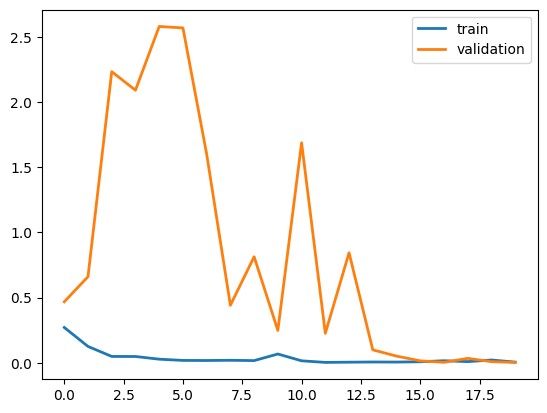

In [35]:
plt.plot(history.history['loss'], label='train', linewidth=2)
plt.plot(history.history['val_loss'], label='validation', linewidth=2)
plt.legend(loc='upper right')
plt.show()

In [36]:
preds = model.predict(x_test)
pred_classes = preds.argmax(1)
true_classes = y_test.argmax(1)

14/14 [==============================] - 1s 10ms/step


In [37]:
rocs = {}
prs = {}
for i in range(2):
    fpr, tpr, _ = sk_metrics.roc_curve(y_test[:,i], preds[:,i])
    prec, rec, _ = sk_metrics.precision_recall_curve(y_test[:,i], preds[:,i])
    rocs[i] = {'fpr':fpr, 'tpr':tpr}
    prs[i] = {'rec':rec, 'prec':prec}
auroc = sk_metrics.roc_auc_score(y_test, preds, average=None, multi_class='ovo')
prauc = sk_metrics.average_precision_score(y_test, preds, average=None)

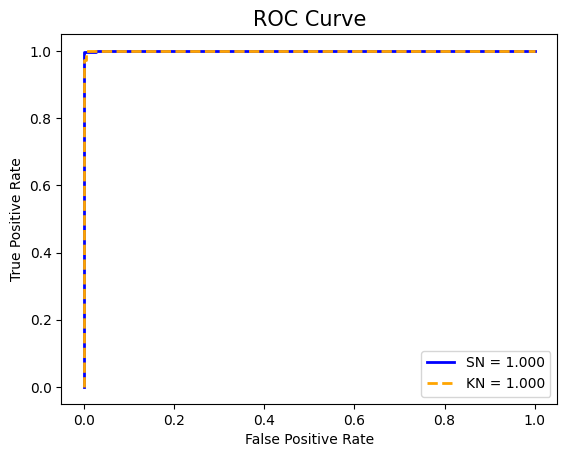

In [38]:
colors = ['b', 'orange']
classes = ['SN', 'KN']
ls = ['-', '--']
for k, v in rocs.items():
    plt.plot(v['fpr'], v['tpr'], color=colors[k], ls=ls[k], label='{} = {:4.3f}'.format(classes[k], auroc[k]), linewidth=2)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=15)
plt.show()

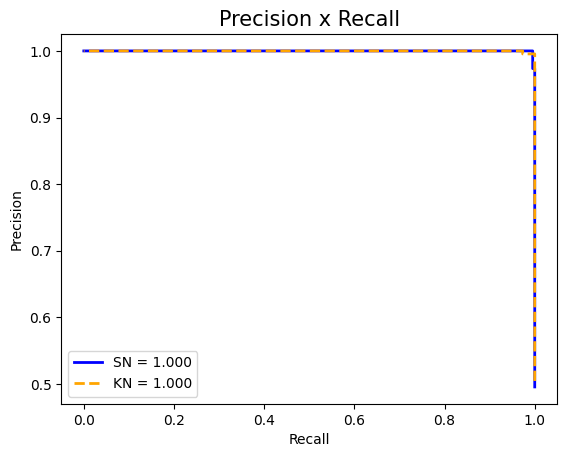

In [39]:
for k, v in prs.items():
    plt.plot(v['rec'], v['prec'], color=colors[k], ls=ls[k], label='{} = {:4.3f}'.format(classes[k], prauc[k]), linewidth=2)
plt.legend(loc='lower left')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision x Recall', fontsize=15)
plt.show()

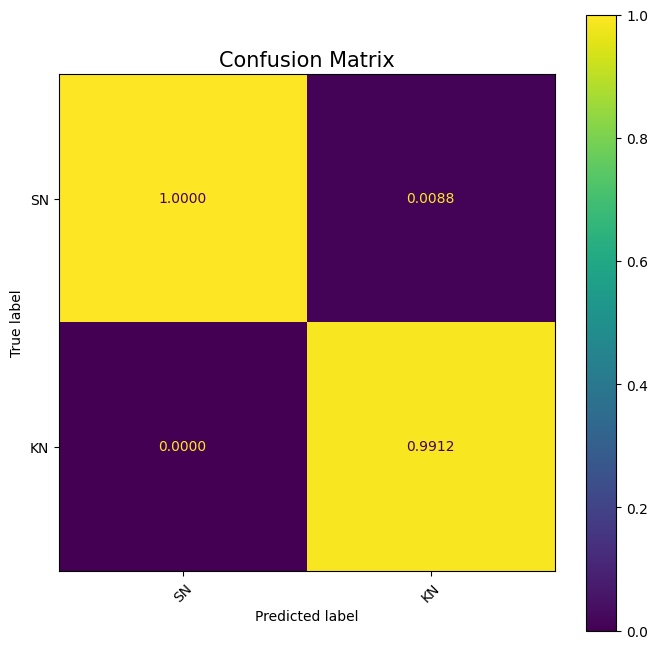

In [40]:
f, ax = plt.subplots(figsize=[8,8])

plot = sk_metrics.ConfusionMatrixDisplay.from_predictions(true_classes, pred_classes, xticks_rotation=45,
                                                          display_labels=classes,
                                                          normalize='pred', ax=ax, values_format='.4f')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

And here are the results from the test using the Kilonova GW170817 SEDs.

In [41]:
predsKN = model.predict(test_kn)
pred_classesKN = predsKN.argmax(1)
days_after = kn_time_cut - 57982.528524

1/1 [==============================] - 0s 118ms/step


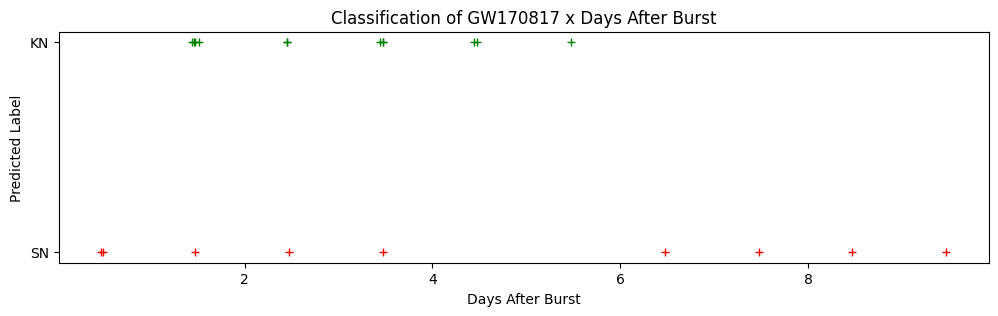

In [42]:
plt.figure(figsize=(12,3))
for i, pred in enumerate(pred_classesKN):
  if pred == 0:
    plt.plot(days_after[i], pred, 'r+')
  elif pred == 1:
    plt.plot(days_after[i], pred, 'g+')
plt.yticks([0, 1], ['SN', 'KN'])
plt.xlabel('Days After Burst')
plt.ylabel('Predicted Label')
plt.title('Classification of GW170817 x Days After Burst')
plt.show()

##**Conclusions**

From the outputs, we can observe that the data and the network still need adjustments. Despite the attempt to make the data look consistent with one another, the Kilonovae's simulated SEDs are still easy to identify.

It is in our interest know if the network is able to identify the Kilonovae's SEDs, and how fast it can recognize them. So, we expect the model to achieve better results on the test with the Kilonova GW170817 dataset, preferably predicting correctly mainly in the first days after the burst.

Given these factors, the project is currently in the adjustment phase, both for data preprocessing and for the network, in search of stronger and more conclusive results.